In [1]:
import sys

sys.path.append("/nfs/dust/belle2/user/kapitanl/Analysis/PRG_MPI/thumair_jpsiks/pythonTools")
sys.path.append("/nfs/dust/belle2/user/kapitanl/Analysis/PRD_MPI/Lib_Xgboost/xgboost/python-package")
!{sys.executable} -m pip install iminuit==2.2.1

%env TOERASEDIR=/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/filesForRemove

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/bin/python3.6m -m pip install --upgrade pip' command.
env: TOERASEDIR=/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/filesForRemove


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rootTools as tap
#import rootTools as tap

Welcome to JupyROOT 6.20/04


In [3]:
import noteBookTools as nbt
totDicts = nbt.getDictForBDT()
listVars = [totDict['var'] for totDict in totDicts] + ['KFold', 'TagVLBoost', 'TagVmcLBoost', 'TagVLBoostErr']
listFormulas = [totDict['form'] for totDict in totDicts] + ['__event__ % 2', 'TagVLBoost', 'TagVmcLBoost', 'TagVLBoostErr']

totDictKins = nbt.getDictForBToDPi("B0toJPsiKStoMuMu")
listVarKins = [totDictKin['var'] for totDictKin in totDictKins]
listFormulaKins = [totDictKin['form'] for totDictKin in totDictKins]

In [4]:
fName = '/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/datafortres.csv'
tupleDir = "/nfs/dust/belle2/user/jkandra/MC13-04/B0toJPsiKStoMuMu/"

In [5]:
#from root_pandas import read_root
#Data = read_root(tupleDir+"B0toJPsiKStoMuMu.root", "B0ToJPsi_mumuKS_pipi")
Data = tap.getPandaFromFiles(fileNames=[tupleDir+"B0toJPsiKStoMuMu.root"],
                               listVarFormulas=listFormulas + listFormulaKins,
                               listVarNames=listVars + listVarKins, 
                               treeName="B0ToJPsi_mumuKS_pipi", cut="isSignal")


........... 


607946
607946
[ -62.85481155 -250.67855604  -55.09834737 ...  -32.50606824  -32.50606824
    8.23397189]


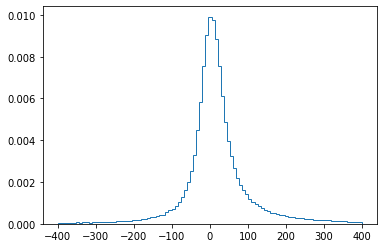

In [8]:
vDatamc = Data["TagVmcLBoost"].to_numpy()
vData = Data["TagVLBoost"].to_numpy()
vDataRes = 1e4*np.subtract(vData,vDatamc)
vSig = (1e4*Data["TagVLBoostErr"]).to_numpy()

print(vData.size)
vData = vData[~np.isnan(vData)]
print(vData.size)


plt.hist(vDataRes, histtype='step', density = True, bins=np.linspace(-400, 400, 100))
print(vDataRes)

In [9]:
def gausInt(a, b, c, d):
     m = d / c
     s = 1./np.sqrt(c)
     from math import erf
     res = np.sqrt(np.pi)/(2*np.sqrt(c)) * (erf((b*c-d)/np.sqrt(c)) - erf((a*c-d)/np.sqrt(c)))
     
     return res

def convExpGaus(sK, tau, x):
     c = 1./(2*sK*sK)
     d = 0.5*(x/sK/sK - 1/tau)
     Const = 1./(np.sqrt(2*np.pi) *sK* tau) * np.exp(-1./2 * pow(x/sK,2) + d*d/c)
     return Const * gausInt(0, 1e15, c, d);
  
def Gauss(x, mean, sigma):
    f = 1./(np.sqrt(2*np.pi)*sigma) * np.exp( -1./2 * pow((x-mean)/sigma, 2))
    return f

def fun(x, pars):
    fTMains = pars["fTMains"]
    fTR     = pars["fTR"]
    sigmas  = pars["sigmas"]
    cLMs    = pars["cLMs"]
    cRMs    = pars["cRMs"]
    mus     = pars["mus"]
    
    bigSigmaFrac = pars['bigSigmaFrac']
    fTBigs = pars['fTBigs']
    bigSigmaScale = pars['bigSigmaScale']
    cLBs = pars['cLBs']
    cRBs = pars['cRBs']
    
    ret = 0
    
    # small gauss
    ret += (1-bigSigmaFrac) * (1-fTMains) * Gauss(x, mean=mus, sigma=sigmas)
    ret += (1-bigSigmaFrac) * fTMains*(1.-fTR)*convExpGaus(sigmas, 1./cLMs, mus - x)
    ret += (1-bigSigmaFrac) * fTMains*(fTR)*convExpGaus(sigmas, 1./cRMs,  x - mus )
    # big gauss
    ret += bigSigmaFrac * (1-fTBigs) * Gauss(x, mean=mus, sigma=bigSigmaScale*sigmas)
    ret += bigSigmaFrac * fTBigs*(1.-fTR)*convExpGaus(bigSigmaScale*sigmas, 1./cLBs, mus - x)
    ret += bigSigmaFrac * fTBigs*(fTR)*convExpGaus(bigSigmaScale*sigmas, 1./cRBs,  x - mus )
    
    return ret




In [10]:
import chebFitter as chf
xLim = 500
ch = chf.chebFitter(128 + 1, -xLim, xLim, vDataRes, fun)
#pars = {"mus" : 0, "sigmas" : 30,  "fTMains" : 0.9, "fTR" : 0.5, "fTBigs":0.1, "cLMs" : 0.1, "cRMs" : 0.1, "cLBs":0.1, "cRBs":0.1, "bigSigmaScale":5, "bigSigmaFrac":0.1 }
pars = {'mus': 3.4601012436145737, 'sigmas': 32.44051535014326,
        'fTMains': 0.3617774600721414, 'fTR': 0.42584121440034417, 
        'fTBigs': 0.9999999586828339, 'cLMs': 0.00012545638295162598,
        'cRMs': 0.006876154494657452, 'cLBs': 0.049999997789230144, 
        'cRBs': 0.04990316913463097, 'bigSigmaScale': 4.575150203695135, 
        'bigSigmaFrac': 0.1925281909303781}
Limits = { 
        'mus': (-10, 10),
        'sigmas': (10, 40),
        'fTMains': (0, 1),
        'fTR': (0, 1),
        'cLMs': (1e-5, 0.1),
        'cRMs': (1e-5, 0.1),
         "bigSigmaScale": (3, 40),
        'bigSigmaFrac' : (0,1),
        'fTBigs' : (0,1),
        'cLBs' : (1e-5, 0.05),
        'cRBs' : (1e-5, 0.05)
        }


res =  ch.fitData(pars, Limits)
print(res)


Loading data grid
Done


/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/chebFitter/python/chebFitter.py:122: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


{'mus': 3.4601012436145737, 'sigmas': 32.44051535014326, 'fTMains': 0.3617774600721414, 'fTR': 0.42584121440034417, 'fTBigs': 0.9999999586828339, 'cLMs': 0.00012545638295162598, 'cRMs': 0.006876154494657452, 'cLBs': 0.049999997789230144, 'cRBs': 0.04990316913463097, 'bigSigmaScale': 4.575150203695135, 'bigSigmaFrac': 0.1925281909303781}


In [15]:
 
def plotHist(d, bins, chFit, res):
    vals, bins = np.histogram(d, bins)
    xCnt  = (bins[1:] + bins[:-1]) / 2
    xSize = (bins[1:] - bins[:-1]) / 2
    print('vals',vals)
    
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios':[16,3]}, figsize=(12,8))
    axs[0].set_yscale('log')
    axs[0].errorbar(xCnt, vals, xerr=xSize, yerr=np.sqrt(vals), ls='none', fmt="o")
    
    N = np.dot(vals, 2*xSize) 
    x = np.linspace(bins[0], bins[-1], 500)
    y = N * chFit.funFast(x, res)
    axs[0].plot(x, y, label='B0toJPsiKStoMuMu')
    axs[0].legend(loc='upper right', shadow=True, fontsize='x-large')
    # plotRatio
    yRat= N * chFit.funFast(xCnt, res)
    axs[1].errorbar(xCnt, vals/ yRat, xerr=xSize, yerr=np.sqrt(vals)/yRat, ls='none', fmt="o")

    dirName = "/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/"
    fig.savefig(dirName+"B0toJPsiKStoMuMu_deltat1D.png", bbox_inches='tight')

    

vals [   89    92    91    93    69    91    81   102   111   105   102   102
   100   106   121   105   112   106    87   119   122   125   133   147
   136   156   132   172   165   161   185   171   180   202   194   189
   181   191   217   194   237   219   208   233   246   255   277   305
   294   317   316   298   364   395   381   411   395   390   478   490
   514   592   585   599   609   725   710   776   782   925   871   990
  1027  1144  1192  1281  1555  1663  1844  1975  2093  2331  2605  2962
  3360  3810  4429  5127  5935  6768  8097  9477 11453 13624 16272 19024
 22127 24759 27167 28495 28289 27399 25798 23247 21129 18491 16036 14018
 12099 10930  9395  8553  7410  6755  5834  5413  4911  4411  4184  3688
  3324  3084  2852  2703  2500  2341  2185  2055  1944  1820  1735  1570
  1521  1479  1384  1299  1243  1149  1141  1064  1064  1016   826   926
   872   787   787   779   711   699   654   626   627   579   568   497
   508   505   528   477   491   441   465   4

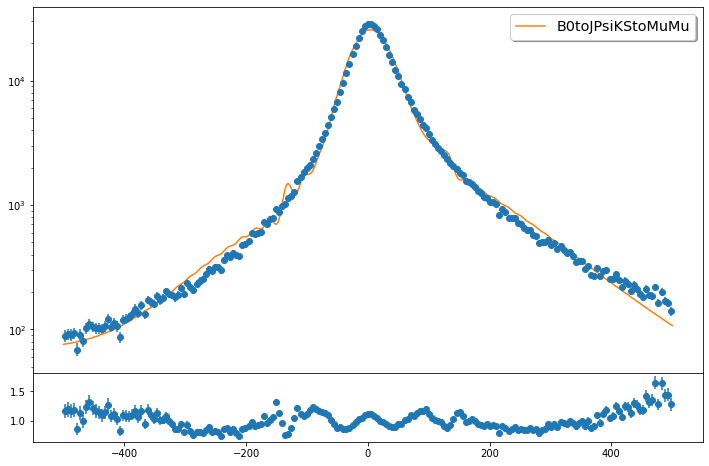

In [16]:
plotHist(vDataRes, np.linspace(-xLim, xLim, 200), ch, res)
